# Biweekly Report 6

## EDA on PascalVOC

### Logan Barnhart

Since we've recently moved on from simple image classification to object detection, let's delve a little deeper into a classic dataset for this. Today we'll be exploring PascalVOC, a great classic dataset for object detection that was made in 2007!

In [109]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### Dataset Metadata

Let's quickly download the data and take a brief look at the metadata:

In [110]:
ds, info = tfds.load("voc", with_info = True)

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='~/tensorflow_datasets/voc/2007/4.0.0',
    file_format=tfrecord,
    download_size=868.

From the cell above, we can see that this dataset was originally created for two types of classifications, the first being just to predict all the labels that are contained in the image, while the other is a more classical object detection task of correctly bounding and labeling the separate components in each image. 

There are roughly 10,000 images in the dataset each containing at least one label, but potentially more. There are around 24,000 components that have been labeled across all images. 

There's a couple things important to note in the FeaturesDict section:
  * 'image' contains the image data
  * 'labels' contains all 20 possible labels
  * 'objects' contains several important things:
    * 'bbox' contains the information for the bounding boxes of each image
    * 'label' contains the labels for each bounding box

If that's a little confusing right now, everything above will make more sense once we start trying to visualize the data!

The only other things to note is that we cannot download the dataset with `as_supervise = True` because each image might contain more than a single label. 

And lastly the training set has 2501 examples, the validation set has 2510 examples, and the test set has 4952 examples.

Here's all the information about our labels:

In [ ]:
print(info.features["labels"].num_classes)
print(info.features["labels"].names[:10])
print(info.features["labels"].names[10:])

20
['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow']
['diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


# Visualizing the Data

Okay, let's take a look at the pictures!

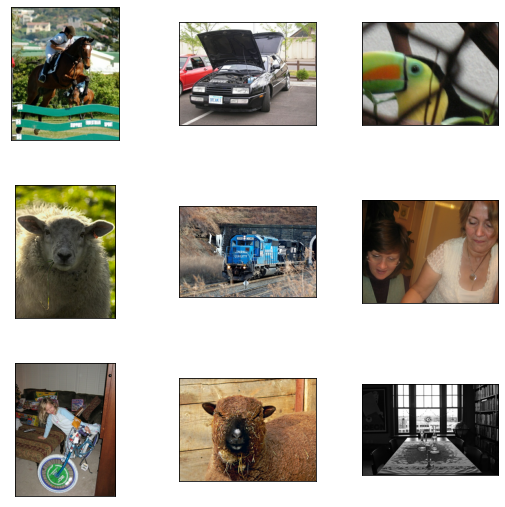

In [ ]:
fig = tfds.visualization.show_examples(ds['train'], info)

So, normally with images that contain just a single label `tfds.visualization.show_examples` will show each label along with the image, but we can see now that we have some issues since we're now doing object detection and each picture could contain multiple labels. 

We also have no idea from this visualization what the 'correct' bounding boxes would be. 

Let's figure out a way to visualize the boxes and labels too. We'll do it for just one image first and then we can generalize. 

In [ ]:
train_ds = tfds.load("voc", split = 'train') # only need a few examples, let's just work with the training data. 

Here's the first image we'll be visualizing:

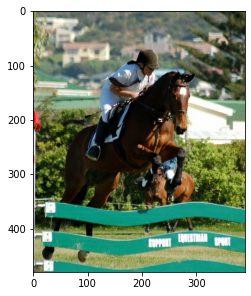

In [111]:
example = next(iter(train_ds)) # grabs one example from dataset
img, boxes, labels = example['image'], example['objects']['bbox'], example['objects']['label']
plt.imshow(img)

Let's examine the information given to us in `boxes` and `labels`.

In [ ]:
print(boxes[0])
print(labels)

tf.Tensor([0.14375    0.0437018  0.97083336 0.7763496 ], shape=(4,), dtype=float32)
tf.Tensor([12 14 12 14], shape=(4,), dtype=int64)


Okay, in `boxes[0]` - the information for the first bounding box - we're given four decimals between 0 and 1. Each one of these values correlates to $y_{min}, x_{min}, y_{max}, x_{max}$ respectively . As you can see though, the image dimensions are ~400 x ~500, so definitely those numbers aren't large enough to be the bounding boxes. 

It turns out that the decimals are actually the ratio of a coordinate to the image width / height. i.e. 

$x_{min} = x_{b, 1} * w$ 

where $x_{min}$ is the real coordinate of the minimum x value, $x_{b,1}$ is the first x value provided to us in `boxes[0]`, and $w$ is the image width.

We can also see that there are 4 labels in this image, so we will have 4 bounding boxes each correlating to one of those. 

I think we have what we need to correctly plot all the bounding boxes!

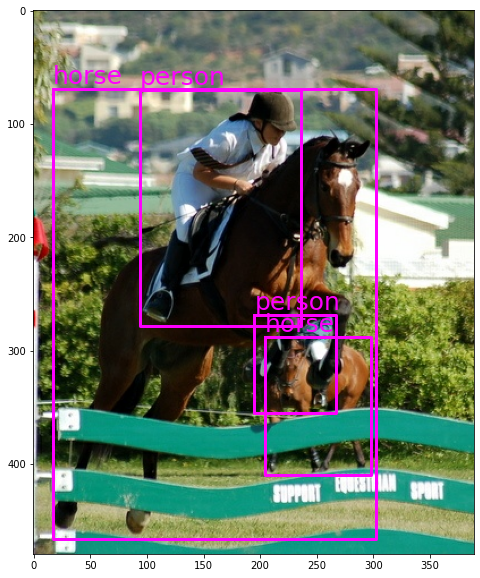

In [175]:
# save class information for converting labels as integers to strings.
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 
           'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

example = next(iter(train_ds))
img, boxes, labels = example['image'], example['objects']['bbox'], example['objects']['label']

width = img.shape[1]
height = img.shape[0]

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(img) #plot image first, then we'll plot boxes over it.

for box, label in zip(boxes, labels):
  #First extract x,y ratios
  ymin, xmin, ymax, xmax = box 

  #Convert ratios to coordinates
  ymin *= height
  ymax *= height
  xmin *= width
  xmax *= width
  
  #plot box
  ax.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color = 'fuchsia', linewidth = 3)
  
  #Coordinates to make labels look nice... most of the time.
  textx = xmin
  texty = ymin - 5

  #plot the label as a string
  ax.text(textx, texty, classes[label], color = 'fuchsia', fontsize = 25)
plt.show()


Woohoo!! That looks great, It's going to be pretty difficult if not impossible to plot the labels in a way that they never overlap with something else so I'm happy with that for now. 

It looks like even the cut off horse and person in the background are both labeled so that explains why we had four labels. 

I do remember seeing an `'is_difficult` section under `'objects'` which if I had to guess would just be `True` if one box / label is hard to correctly detect. That person in the back seems like it would be difficult to correctly bound and label, so let's check.

In [ ]:
print(example['objects']['is_difficult'])

tf.Tensor([False False False  True], shape=(4,), dtype=bool)


Okay, one of them is difficult, is it the person?

In [ ]:
print(classes[example['objects']['label'][3]])

person


Yep! It appears that labeling that person is considered difficult. makes sense considering only their legs are visible.

Finally let's just visualize a bunch of images and make sure everything works! Note that nearly all the code below will be the same as above, so there's nothing really new here to note.

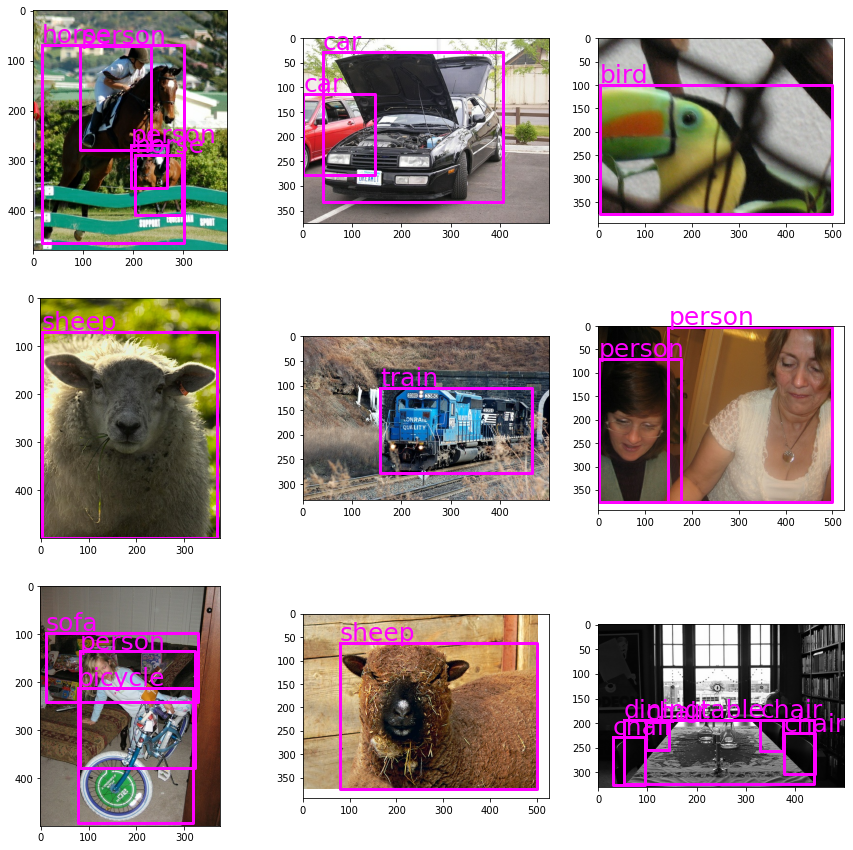

In [176]:
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

iterator = iter(train_ds)

fig, ax = plt.subplots(3, 3, figsize = (15,15))

row = 0
col = 0

for _ in range(9):
  example = next(iterator)
  img, boxes, labels = example['image'], example['objects']['bbox'], example['objects']['label']
  width = img.shape[1]
  height = img.shape[0]
  ax[row][col].imshow(img)
  for box, label in zip(boxes, labels):
    ymin, xmin, ymax, xmax = box
    ymin *= height
    ymax *= height
    xmin *= width
    xmax *= width
    
    ax[row][col].plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color = 'fuchsia', linewidth = 3)
    textx = xmin
    texty = ymin - 5
    ax[row][col].text(textx, texty, classes[label], color = 'fuchsia', fontsize = 25)

  col += 1
  if col % 3 == 0:
    row += 1
    col = 0

plt.show()  

Now we kind of know what's going on with each image. Let's get into more actual analysis.

### How many labels are typically in an image?

Exactly how it sounds, let's figure it out. 

In [138]:
labelcounts = []

iterator = iter(ds['train']) # first iterate over training data

for _ in range(2501):
  ex = next(iterator)
  labels = ex['objects']['label']
  numlabels = len(labels)
  labelcounts += [numlabels]

iterator = iter(ds['test']) # then iterate over testing data

for _ in range(4952):
  labels = next(iterator)['objects']['label']
  numlabels = len(labels)
  labelcounts += [numlabels]

iterator = iter(ds['validation']) # lastly iterate over validation data

for _ in range(2510):
  labels = next(iterator)['objects']['label']
  numlabels = len(labels)
  labelcounts += [numlabels]

(array([8.549e+03, 9.770e+02, 2.760e+02, 9.100e+01, 3.700e+01, 1.700e+01,
        8.000e+00, 2.000e+00, 4.000e+00, 2.000e+00]),
 array([ 1. ,  5.1,  9.2, 13.3, 17.4, 21.5, 25.6, 29.7, 33.8, 37.9, 42. ]),
 <a list of 10 Patch objects>)

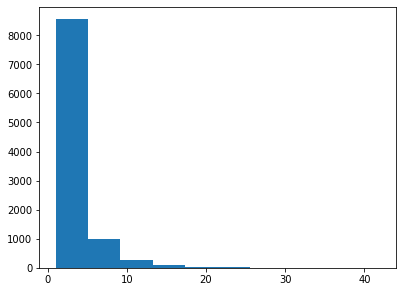

In [139]:
plt.hist(labelcounts) # plot results as histogram

In [181]:
print('Highest number of labels in an image: ', max(labelcounts))
print('Fewest number of labels in an image: ', min(labelcounts))
print('Avg. number of labels in an image: ', np.mean(labelcounts))

Highest number of labels in an image:  42
Fewest number of labels in an image:  1
Avg. number of labels in an image:  3.0751781591889995


So most images have 1-8 labels but there are definitely a few outliers. There's even an image with 42 labels in it! That's kind of insane. Let's see if we can find that one and take a look. 

In [178]:
iterator = iter(ds['validation']) # it turned out it was in the validation dataset

for _ in range(4952): # iterate through until we find the one with 42 labels
  ex = next(iterator)
  labels = ex['objects']['label']
  numlabels = len(labels)
  if numlabels == 42:
    print('Success!') # we found it!
    break

Success!


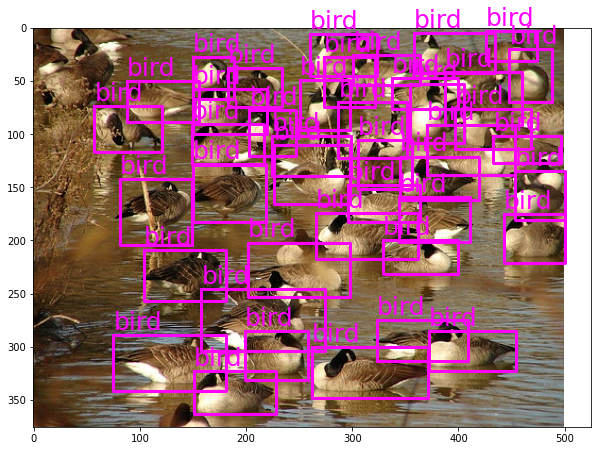

In [179]:
# same code as before!
img, boxes, labels = ex['image'], ex['objects']['bbox'], ex['objects']['label']

width = img.shape[1]
height = img.shape[0]

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(img) 

for box, label in zip(boxes, labels):
  ymin, xmin, ymax, xmax = box 
  ymin *= height
  ymax *= height
  xmin *= width
  xmax *= width
  ax.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color = 'fuchsia', linewidth = 3)
  textx = xmin
  texty = ymin - 5
  ax.text(textx, texty, classes[label], color = 'fuchsia', fontsize = 25)
plt.show()

LOL! Not sure why but that's really funny to me. Well, I'm not going to count them, I trust the labeler. It actually looks like there's even a few geese that are not being counted, very interesting. Just out of curiosity, are any of them difficult to label?

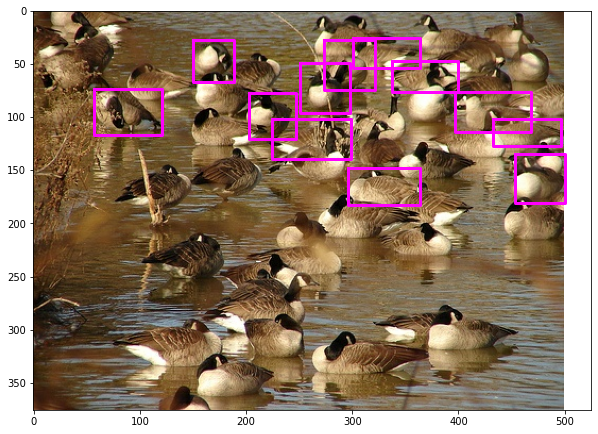

In [180]:
difficultidxs = []

for i in range(42): # collect all the indices where is_difficult = True 
  if ex['objects']['is_difficult'][i]:
    difficultidxs += [i]

fig, ax = plt.subplots(figsize = (10,10))
ax.imshow(img) 

for i in difficultidxs: # plot all is_difficult = True boxes
  box= ex['objects']['bbox'][i]
  ymin, xmin, ymax, xmax = box 
  ymin *= height
  ymax *= height
  xmin *= width
  xmax *= width
  ax.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color = 'fuchsia', linewidth = 3)
plt.show()

Alright, not very insightful but interesting nonetheless. I wonder how the `is_difficult` was even created, perhaps it was after the competition with the boxes that were missed / mislabeled most frequently? This is actually a perfect segway into the next section.

### How many boxes are difficult to label in the entire dataset?

We know there are ~24,000 things to possibly label, it would probably be useful to know exactly how many are difficult to label.

In [157]:
traindiffcount = 0
iterator = iter(ds['train'])

for _ in range(2501):
  ex = next(iterator)
  diff = ex['objects']['is_difficult']
  for x in diff:
    if x == True:
      traindiffcount += 1

testdiffcount = 0
iterator = iter(ds['test'])

for _ in range(4952):
  ex = next(iterator)
  diff = ex['objects']['is_difficult']
  for x in diff:
    if x == True:
      testdiffcount += 1

valdiffcount = 0
iterator = iter(ds['validation'])

for _ in range(2510):
  ex = next(iterator)
  diff = ex['objects']['is_difficult']
  for x in diff:
    if x == True:
      valdiffcount += 1

print(f'Difficult labels in entire dataset: {traindiffcount + testdiffcount + valdiffcount} --- percentage of labels that are difficult: {(traindiffcount + testdiffcount + valdiffcount)/9963 * 100}')
print(f'Difficult labels in training data: {traindiffcount} --- percentage of labels that are difficult: {traindiffcount / 2501 * 100}')
print(f'Difficult labels in testing data: {testdiffcount} --- percentage of labels that are difficult: {testdiffcount / 4952 * 100}')
print(f'Difficult labels in validation data: {valdiffcount} --- percentage of labels that are difficult: {valdiffcount / 2510 * 100}')

Difficult labels in entire dataset: 5998 --- percentage of labels that are difficult: 60.202750175649896
Difficult labels in training data: 1543 --- percentage of labels that are difficult: 61.695321871251494
Difficult labels in testing data: 2944 --- percentage of labels that are difficult: 59.45072697899838
Difficult labels in validation data: 1511 --- percentage of labels that are difficult: 60.199203187250994


Wow, so actually a majority of the labels are difficult! Thanfully the number of difficult ones is consistent between splits, so that shouldn't drastically alter the accuracy between training, validation, and testing. Alright, one last thing we're going to check to see how models will perform on this data.

# Total occurences for each label?

Now we're just going to check how many time each label occurs across all the images. 



In [171]:
trainlabeltotals = [0] * 20
testlabeltotals = [0] * 20
vallabeltotals = [0] * 20

iterator = iter(ds['train'])

for _ in range(2501): # iterate over training data
  ex = next(iterator)
  labels = ex['objects']['label']
  for label in labels:
    trainlabeltotals[label] += 1

iterator = iter(ds['test']) # then iterate over testing data

for _ in range(4952):
  ex = next(iterator)
  labels = ex['objects']['label']
  for label in labels:
    testlabeltotals[label] += 1

iterator = iter(ds['validation']) # lastly iterate over validation data

for _ in range(2510):
  ex = next(iterator)
  labels = ex['objects']['label']
  for label in labels:
    vallabeltotals[label] += 1

labeltotals = [x + y + z for x, y, z in zip(trainlabeltotals, testlabeltotals, vallabeltotals)] # add all 3 totals together

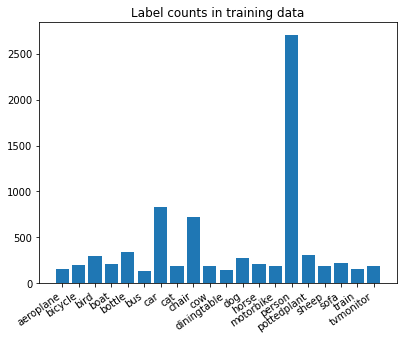

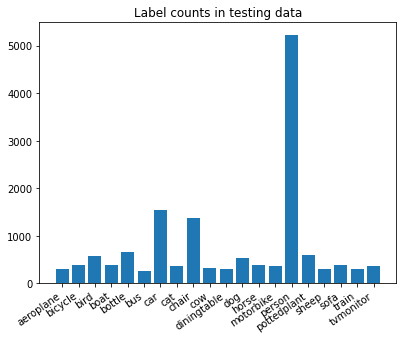

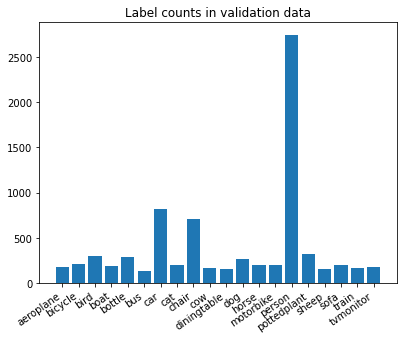

Text(0.5, 1.0, 'Label counts in all data')

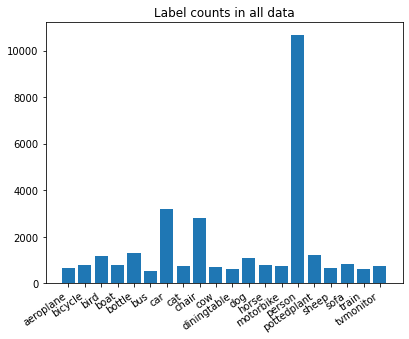

In [173]:
#plotting all the totals!
plt.bar(classes, trainlabeltotals)
plt.xticks(ticks = classes, rotation=35, ha='right')
plt.title('Label counts in training data')
plt.show()
plt.bar(classes, testlabeltotals)
plt.xticks(ticks = classes, rotation=35, ha='right')
plt.title('Label counts in testing data')
plt.show()
plt.bar(classes, vallabeltotals)
plt.xticks(ticks = classes, rotation=35, ha='right')
plt.title('Label counts in validation data')
plt.show()
plt.bar(classes, labeltotals)
plt.xticks(ticks = classes, rotation=35, ha='right')
plt.title('Label counts in all data')


Okay, so as we can see in each split of the data, the amounts for each label seems to be pretty consistent. The only thing is theres a dramatically large amount of people in the images and a pretty large amount of cars and chairs. This might lead to more accuracy on the images containing people, chairs, and cars, but could also lead to poor performance on other labels. 

Obviously this can be alleviated slightly with data augmentation, but you'll still have plenty more people than other labels. 

### Conclusions

This was a really fun dataset to explore. I think it's a great introduction to object detection although it seems quite different from the examples we've seen in class since this is region-wise predictions instead of pixel-wise predictions. 

In a future report I may end up exploring the performance of a pretrained model on images with people vs without people to see if there's any dramatic difference. 



## Citations

The following post helped me when I was trying to visualize the data: 

https://stackoverflow.com/questions/56025263/how-to-use-the-pascal-voc-dataset-in-the-xml-format-to-build-the-model-in-tensor 